In [1]:
from seasonstats import *
import statsmodels.api as sm
import pickle

In [2]:
from getData import *

# Get "Preseason" Data

In [5]:
testtalent = pd.DataFrame()
for year in [2018,2019,2020,2021,2022,2023]:
    testtalent = pd.concat([testtalent,getData('talent',{'year':year})])

In [8]:
testtalent = testtalent.reset_index(drop=True)
testtalent['talent']=testtalent['talent'].astype(float)

In [95]:
testreturning= pd.DataFrame()
for year in [2018,2019,2020,2021,2022,2023]:
    testreturning = pd.concat([testreturning,getData('player/returning',{'year':year})])

#testtalent.sort_values('talent',ascending=False)

In [223]:
testreturning[['season','team','percentPPA']]
testtalent

preseasondata = pd.merge(testreturning[['season','team','percentPPA']],testtalent,how='left',left_on=['season','team'],right_on=['year','school'])

# Calculate Win% of Preseason Data

In [225]:
preseasondata[['season','team','percentPPA','talent']]

,season,team,percentPPA,talent
0,2018,Air Force,0.667,186.27
1,2018,Akron,0.335,361.00
2,2018,Alabama,0.780,978.54
3,2018,Appalachian State,0.324,356.16
4,2018,Arizona,0.744,580.54
...,...,...,...,...
773,2023,Western Kentucky,0.461,491.26
774,2023,Western Michigan,0.540,401.82
775,2023,West Virginia,0.348,666.23
776,2023,Wisconsin,0.592,741.63


In [228]:
testgames = pd.DataFrame()
for year in [2018,2019,2020,2021,2022,2023]:
    testgames = pd.concat([testgames,getData('games',{'year':year,'division':'fbs'})])

In [234]:
testgames2 = testgames.query("(home_division=='fbs')&(away_division=='fbs')")[['season','home_team','away_team','home_points','away_points']].copy()
testgames2.columns = ['season','team','opp','points','allowed']
testgames2b = testgames2.copy()
testgames2b.columns = ['season','opp','team','allowed','points']
testgames2b



,season,opp,team,allowed,points
2,2018,Colorado State,Hawai'i,34,43
3,2018,New Mexico State,Wyoming,7,29
6,2018,Minnesota,New Mexico State,48,10
7,2018,Connecticut,UCF,17,56
9,2018,Purdue,Northwestern,27,31
...,...,...,...,...,...
863,2023,Tulane,SMU,14,26
864,2023,Troy,Appalachian State,49,23
865,2023,Florida State,Louisville,16,6
866,2023,Iowa,Michigan,0,26


In [246]:
testpreseason = pd.concat([testgames2,testgames2b]).merge(preseasondata[['season','team','percentPPA','talent']],
                                         how='left',on=['season','team']).merge(preseasondata[['season','team','percentPPA','talent']],
                                         how='left',left_on=['season','opp'],right_on=['season','team'])\
.assign(win = lambda x: (x['points']>x['allowed']).astype(int)).query("talent_x != 0").dropna()

In [251]:
testpreseason

Xl = testpreseason[['percentPPA_x','talent_x']]
Xl = sm.add_constant(Xl)
Yl = testpreseason['win']

prelog = sm.Logit(Yl,Xl).fit()

Optimization terminated successfully.
         Current function value: 0.675949
         Iterations 4


In [384]:
prelog.summary()

#with open("models/preseason.pickle", 'wb') as f:
#    pickle.dump(prelog,f)


In [254]:
prelog.predict([1,1,1000]),prelog.predict([1,.1,1000]),prelog.predict([1,1,500]),prelog.predict([1,.1,500])

(array([0.74856624]),
 array([0.58074794]),
 array([0.55173683]),
 array([0.36413885]))

# Calculate Preseason Expectations

In [24]:
with open('data/ratings/2018offense.pkl','rb') as f:
    off18 = pickle.load(f)
with open('data/ratings/2018defense.pkl','rb') as f:
    def18 = pickle.load(f)
with open('data/ratings/2019offense.pkl','rb') as f:
    off19 = pickle.load(f)
with open('data/ratings/2019defense.pkl','rb') as f:
    def19 = pickle.load(f)

In [256]:
preseasondf = preseasondata[['season','team','percentPPA','talent']].copy()
preseasondf['expWin']=prelog.predict(sm.add_constant(preseasondf[['percentPPA','talent']]))

In [276]:
ypp18 = pd.merge(pd.DataFrame.from_dict(off18['ypp'],orient='index',columns=['ypp_off']).assign(year = 2018),
pd.DataFrame.from_dict(def18['ypp'],orient='index',columns=['ypp_def']).assign(year = 2018),how='left',left_index=True,right_index=True)

ypp18['team']=ypp18.index

ypp19 = pd.merge(pd.DataFrame.from_dict(off19['ypp'],orient='index',columns=['ypp_off']).assign(year = 2019),
pd.DataFrame.from_dict(def19['ypp'],orient='index',columns=['ypp_def']).assign(year = 2019),how='left',left_index=True,right_index=True)
ypp19['team']=ypp19.index


<Axes: xlabel='ypp_off_18', ylabel='delta'>

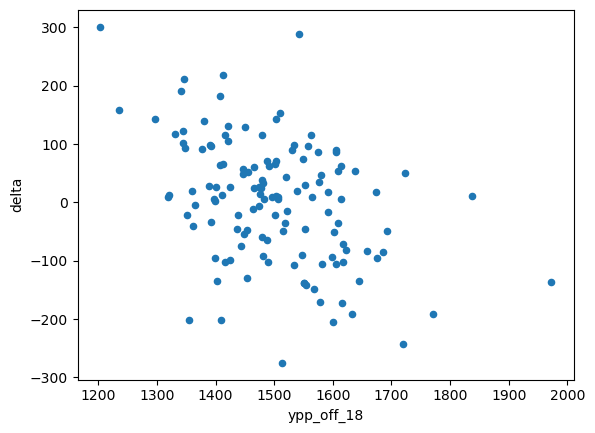

In [292]:
#2019 preseason expectations
pre19 = preseasondf.query("season==2019").merge(ypp18,on='team').merge(ypp19,on='team',suffixes=('_18','_19')).copy()
pre19.assign(delta = lambda x: x['ypp_off_19']-x['ypp_off_18'])\
.plot(x='ypp_off_18',y='delta',kind='scatter')

#.query("ypp_def_18>1500")\

#There is some reversion to the mean (1500)
#Defense = Average of Previous and 1500 with small modifier for talent
#

In [378]:
#Let's see if we can try to balance offense and defense
pre19['oldBalanceOff']=pre19['ypp_off_18']/(pre19['ypp_off_18']+pre19['ypp_def_18'])
pre19['newBalanceOff']=pre19['ypp_off_19']/(pre19['ypp_off_19']+pre19['ypp_def_19'])

pre19['18to19off']=pre19['ypp_off_18']*.6+1500*.4+(pre19['expWin']-.5)*800*pre19['oldBalanceOff']
pre19['18to19def']=pre19['ypp_def_18']*.6+1500*.4+(pre19['expWin']-.5)*400#*(1-pre19['oldBalanceOff'])




pre19[['season','team','expWin','ypp_off_18','ypp_off_19','ypp_def_18','ypp_def_19','18to19off','18to19def','oldBalanceOff','newBalanceOff']]

,season,team,expWin,ypp_off_18,ypp_off_19,ypp_def_18,ypp_def_19,18to19off,18to19def,oldBalanceOff,newBalanceOff
0,2019,Air Force,0.324738,1465,1526,1368,1513,1406.494713,1350.695059,0.517120,0.502139
1,2019,Akron,0.433307,1354,1152,1478,1411,1386.890891,1460.122822,0.478107,0.449473
2,2019,Alabama,0.691793,1837,1848,1763,1643,1780.494189,1734.517224,0.510278,0.529361
3,2019,Appalachian State,0.477720,1456,1508,1641,1603,1465.220447,1575.688092,0.470132,0.484732
4,2019,Arizona,0.493178,1599,1506,1504,1460,1556.587755,1499.671296,0.515308,0.507755
...,...,...,...,...,...,...,...,...,...,...,...
125,2019,Western Kentucky,0.497284,1297,1440,1361,1535,1377.139915,1415.513760,0.487961,0.484034
126,2019,Western Michigan,0.468514,1488,1423,1352,1420,1479.602481,1398.605594,0.523944,0.500528
127,2019,West Virginia,0.461049,1719,1476,1553,1620,1615.029334,1516.219773,0.525367,0.476744
128,2019,Wisconsin,0.568139,1606,1696,1526,1595,1591.551750,1542.855567,0.512771,0.515345


In [379]:
pre19.assign(offmiss = lambda x: abs(x['18to19off']-x['ypp_off_19'])).assign(defmiss = lambda x: abs(x['18to19def']-x['ypp_def_19']))\
[['offmiss','defmiss']].mean()

#OFF 5050 77.13
#Def 60/40 72.85

offmiss    70.312307
defmiss    70.709836
dtype: float64

<Axes: xlabel='expWin', ylabel='offmiss'>

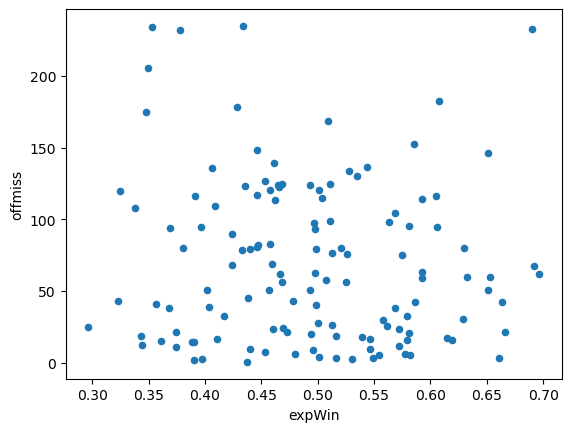

In [380]:
pre19.assign(offmiss = lambda x: abs(x['18to19off']-x['ypp_off_19']))\
.assign(defmiss = lambda x: (x['18to19def']-x['ypp_def_19']))\
.plot(x='expWin',y='offmiss',kind='scatter')



In [381]:
# Check a Ranking Based Version
rank19 = pre19[['season','team','expWin','ypp_off_18','ypp_off_19','ypp_def_18','ypp_def_19','18to19off','18to19def']].copy()
rank19['18total']=rank19['ypp_off_18']+rank19['ypp_def_18']
rank19['predicttotal']=rank19['18to19off']+rank19['18to19def']
rank19['19total']=rank19['ypp_off_19']+rank19['ypp_def_19']
for c in rank19.columns[2:]:
    rank19[c]=rank19[c].rank(ascending=False)


In [382]:
rank19.assign(movers=lambda x: x['18total']-x['predicttotal']).sort_values(by='movers',ascending=False).head(20)

,season,team,expWin,ypp_off_18,ypp_off_19,ypp_def_18,ypp_def_19,18to19off,18to19def,18total,predicttotal,19total,movers
121,2019,Virginia Tech,21.0,51.0,60.0,107.0,46.0,38.0,85.0,92.0,58.0,48.0,34.0
100,2019,Tennessee,6.0,62.5,37.0,38.5,25.0,33.0,20.0,52.0,20.0,24.0,32.0
52,2019,Louisville,29.0,73.5,26.0,123.0,103.0,51.0,100.0,109.0,79.0,62.0,30.0
32,2019,Florida State,14.0,87.5,69.0,36.0,42.0,56.0,27.0,61.0,37.0,46.5,24.0
83,2019,Oregon State,39.0,73.5,52.0,125.0,74.0,59.0,109.0,112.5,89.0,63.0,23.5
82,2019,Oregon,10.0,48.0,17.0,41.0,16.5,26.0,25.0,44.5,21.0,15.0,23.5
62,2019,Minnesota,17.0,56.0,11.0,47.0,44.0,41.0,34.0,57.0,34.0,18.0,23.0
40,2019,Illinois,41.0,42.5,103.0,121.0,69.0,40.0,104.0,95.0,74.0,95.0,21.0
94,2019,Southern Mississippi,42.0,120.0,91.5,32.5,79.0,97.0,33.0,86.0,65.0,87.0,21.0
31,2019,Florida International,48.0,91.0,112.0,113.0,91.0,77.0,103.0,112.5,93.0,111.0,19.5
